In [4]:
# import the necessary packages
from collections import deque
import numpy as np
import argparse
from cv2 import aruco
import cv2
import time
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation
from itertools import product

In [9]:
##### setting #####
# video used to tracking
path_tracking = 'videos/scheibe/1000p/C0604.MP4'
# path_tracking = 'videos/scheibe/500p/C0599.MP4'
# size of aruco [mm]
size_aruco = 0.03            
# size of chessboard [pixel]   
size_chessboard = (2000,2000) 
# axis length drawn in pictures
len_axis = 0.015
# aruco dictionary used in video
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
# camera set
mtx = np.loadtxt("cam_mtx.csv")
dist = np.loadtxt("cam_dist.csv")

In [10]:
class marker():
    def __init__(self, mk_id, mk_type):
        # marker ID
        self.id = mk_id
        
        # marker type:
        # track for tracking
        if mk_type == 'track':
            self.type = mk_type
        # ref for reference system
        elif mk_type == 'ref':
            self.type = mk_type
        
        # rotation offset wrt marker coord.
        self.R_offset = np.identity(3)
        
        # marker transition wrt origin
        self.r_o_mk = np.zeros(3)
        
        # marker rotation wrt origin
        self.R_o_mk = np.identity(3)
        
        
        self.R_cam_mk = np.zeros(3)
        self.r_cam_mk = np.zeros(3)
        
            
mk1 = marker(5,'ref')
mk1.R_offset = Rotation.from_rotvec([0,0,np.pi/2]).as_matrix()

mk2 = marker(2,'ref')
mk2.r_o_mk = np.array([0.237,0,0])
mk2.R_o_mk = Rotation.from_rotvec([0,0,-np.pi/6]).as_matrix()

mk3 = marker(6,'track')
mk3.R_offset = Rotation.from_rotvec([0,0,np.pi/2]).as_matrix()

mk4 = marker(7,'track')
mk4.R_offset = Rotation.from_rotvec([0,0,np.pi/2]).as_matrix()@Rotation.from_rotvec([np.pi,0,0]).as_matrix()

ref_markers = [mk1, mk2]
target_markers = [mk3, mk4]

In [11]:
## get the video for processing
cap = cv2.VideoCapture(path_tracking)


#f_name = args.get('video').replace('.mp4','_tracking.txt')
#f_out = open(f_name, 'w')


t_sequence = []
r_sequence = []
R_sequence = []
mk_sequence = []
# keep looping
fps_ratio = 20
while True:
    # time
    t = cap.get(cv2.CAP_PROP_POS_MSEC)/1000/fps_ratio
    
    # get current frame
    frame = cap.read()[1]
    # end of video
    if frame is None:
        break

    # rotate the current frame
    # frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

    # blur frame
#     frame = cv2.GaussianBlur(frame, (3, 3),1)

    # convert frame color to gray value
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    
    parameters =  aruco.DetectorParameters_create()
    corners, ids, rejected_img_points = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
    
    # Subpixel detection
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)
    if len(corners)>0:
        for corner in corners:
            cv2.cornerSubPix(gray, corner, 
                             winSize = (3,3), 
                             zeroZone = (-1,-1), 
                             criteria = criteria)
            
    # draw markers
    frame = aruco.drawDetectedMarkers(frame, corners, ids)

    
    if corners:
        # Rotation vector, position vector wrt camera
        all_R, all_r, trash = aruco.estimatePoseSingleMarkers(corners, size_aruco , mtx, dist)
        
        active_tars = [mk for mk in target_markers if mk.id in ids]
        active_refs = [mk for mk in ref_markers if mk.id in ids]
        
        # update info in camera coord.
        for mk in active_tars + active_refs:
            idx =  np.where(ids == mk.id)
            R_cam_mk, __jacob = cv2.Rodrigues(all_R[idx])
            mk.R_cam_mk = R_cam_mk@mk.R_offset
            mk.r_cam_mk = all_r[idx][0]
        
        
        # update target info in word coordinates
        for tar in target_markers:
            tar.R_o_mk = np.zeros((3,3))
            tar.r_o_mk = np.zeros(3)
        for (tar, ref) in product(active_tars, active_refs):
            tar.R_o_mk += ref.R_o_mk@ref.R_cam_mk.T@tar.R_cam_mk
            tar.r_o_mk += ref.r_o_mk + ref.R_o_mk@ref.R_cam_mk.T@(tar.r_cam_mk-ref.r_cam_mk)
        tar.R_o_mk /= len(active_refs)
        tar.r_o_mk /= len(active_refs)
            
        # output data if target and ref found
        if active_tars and active_refs:
            r_temp = np.zeros((len(target_markers),3))
            R_temp = np.zeros((len(target_markers),3,3))
            for tar in active_tars:
                r_temp[target_markers.index(tar)] = tar.r_o_mk
                R_temp[target_markers.index(tar)] = tar.R_o_mk
            t_sequence.append(t)
            r_sequence.append(r_temp)
            R_sequence.append(R_temp)
        
        
        
        
        # draw marker
        for mk in active_tars + active_refs:
            frame = aruco.drawAxis(frame, mtx, dist, mk.R_cam_mk, mk.r_cam_mk, len_axis)
            
        
        # 
#         for (tar_mark, ref_mark) in product(target_markers, ref_markers):
#             idx = np.where(ids == tar_mark.id)
#             R_cam_t, __jacob = cv2.Rodrigues(all_R[idx][0])@tar_mark.R_offset
#             r_cam_t = all_r[idx][0]
#             R_cam_t = R_cam_t@track_R_offset[track_targets.index(target)]
            
#             idx = np.where(ids == ref_mark.id)
#             R_cam_t, __jacob = cv2.Rodrigues(all_R[idx][0])
#             r_cam_t = all_r[idx][0]
#             R_cam_t = R_cam_t@track_R_offset[track_targets.index(target)]
        
#         if active_refs and active_targets:
#             r_o_targets = np.zeros((len(track_targets),3))
#             R_o_targets = np.zeros((len(track_targets),3))
#             for target in active_targets:
#                 idx = np.where(ids == target)
#                 R_cam_t, __jacob = cv2.Rodrigues(all_R[idx])
#                 r_cam_t = all_r[idx][0]
#                 R_cam_t = R_cam_t@track_R_offset[track_targets.index(target)]
# #                 frame = aruco.drawAxis(frame, mtx, dist, R_cam_t, r_cam_t, len_axis)
#                 r_o_t_ave = np.zeros(3)
#                 R_o_t_ave = np.zeros(3)
#                 weights = 0
#                 for ref in active_refs:
#                     # get reference coordinates
#                     idx = np.where(ids == ref)
#                     R_cam_ref, __jacob = cv2.Rodrigues(all_R[idx])
#                     r_cam_ref = all_r[idx][0]
#                     R_o_cam = R_o_sys[ref_sys.index(ref)]@R_cam_ref.T
#                     r_o_cam = r_o_sys[ref_sys.index(ref)] - R_o_cam@r_cam_ref


#                     R_o_t = R_o_cam@R_cam_t
#                     r_o_t = r_o_cam + R_o_cam@r_cam_t

#                     weight = np.linalg.norm(R_cam_ref@[0,0,1])
#                     weight = 1
#                     weights += weight
#                     r_o_t_ave += r_o_t*weight
#                     R_o_t_ave += cv2.Rodrigues(R_o_t)[0].reshape((3))*weight
# #                     print(R_o_t)
#                 r_o_t_ave /= weights
#                 R_o_t_ave /= weights
#                 r_o_targets[track_targets.index(target)] = r_o_t_ave
#                 R_o_targets[track_targets.index(target)] = R_o_t_ave
#                 time_sequence.append(t)
#                 r_sequence.append(r_o_targets)
#                 R_sequence.append(R_o_targets)
        # frame = aruco.drawAxis(frame, mtx, dist, np.average(rots,axis=0,weights=weights), np.average(trans,axis=0,weights=weights), len_axis)
#         time.sleep(1)
#     for mk in ref_markers + target_markers:
#         frame = aruco.drawAxis(frame, mtx, dist, cv2.Rodrigues(all_R[idx])[0]@mk.R_offset, all_r[idx][0], len_axis)


    # show the frame to our screen
    frame = cv2.resize(frame, (int(frame.shape[1]/2), int(frame.shape[0]/2)))
    cv2.imshow("Frame", frame)
    
    # if the 'q' key is pressed, stop the loop
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

#f_out.close()

# release the camera
cap.release()

# close all windows
cv2.destroyAllWindows()


r_sequence = np.array(r_sequence)
R_sequence = np.sum(R_sequence,axis=1)

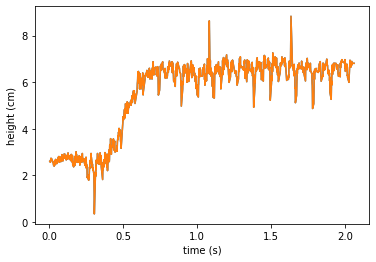

In [12]:

plt.figure()
for i in range(len(target_markers)):
    plt.xlabel('time (s)')
    plt.ylabel('height (cm)')
    plt.plot(t_sequence, np.sum(r_sequence,axis=1)[:,2]*100)
    
# for i in range(len(track_targets)):
#     plt.subplot(2,1,2)
#     plt.xlabel('time (s)')
#     plt.ylabel('angele (grad)')
#     plt.plot(time_sequence,np.rad2deg(angle_sequence))
#     plt.plot(time_sequence, states_sequence[:,0,0])
#     plt.plot(time_sequence, states_sequence[:,1,2])

# plt.plot(time_sequence,states_se quence)
# plt.legend(['1','2','3'])
# plt.plot(np.linspace(0,8.5,100),np.ones(100)*0.18)
# print(np.average(np.array(states),axis=0))

<ipython-input-13-81c4f2a9df47>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,1,1)
<ipython-input-13-81c4f2a9df47>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,1,2)
<ipython-input-13-81c4f2a9df47>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retu

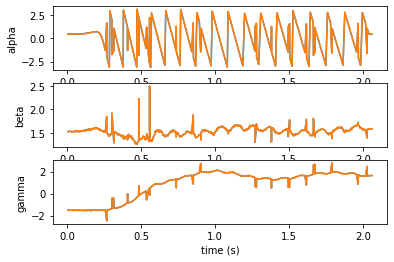

In [13]:
r = Rotation.from_matrix(R_sequence)
r = r.as_euler('zxz')
plt.figure()
for i in range(len(target_markers)):
    plt.subplot(3,1,1)
    plt.xlabel('time (s)')
    plt.ylabel('alpha')
    plt.plot(t_sequence,r[:,2])
    plt.subplot(3,1,2)
    plt.xlabel('time (s)')
    plt.ylabel('beta')
    plt.plot(t_sequence,r[:,1])
    plt.subplot(3,1,3)
    plt.xlabel('time (s)')
    plt.ylabel('gamma')
    plt.plot(t_sequence,r[:,0])

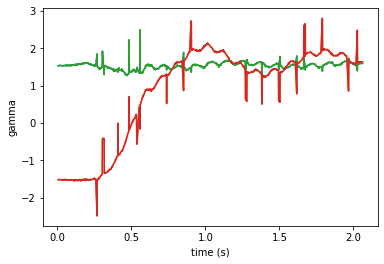

In [15]:
r = Rotation.from_matrix(R_sequence)
r = r.as_euler('zxz')
plt.figure()
for i in range(len(target_markers)):
#     plt.subplot(2,1,1)
    plt.xlabel('time (s)')
    plt.ylabel('beta')
    plt.plot(t_sequence,r[:,1])
#     plt.subplot(2,1,2)
    plt.xlabel('time (s)')
    plt.ylabel('gamma')
    plt.plot(t_sequence,r[:,0])

In [ ]:
states_sequence = np.array(states_sequence)
for i in range(len(track_targets)):
    plt.plot(time_sequence, np.sum(states_sequence,axis=1)[:,2])
#     plt.plot(time_sequence, states_sequence[:,0,0])
#     plt.plot(time_sequence, states_sequence[:,1,2])

# plt.plot(time_sequence,states_se quence)
# plt.legend(['1','2','3'])
# plt.plot(np.linspace(0,8.5,100),np.ones(100)*0.18)
# print(np.average(np.array(states),axis=0))

In [ ]:
plt.plot(time_sequence,states)
plt.legend(['1','2','3'])
# plt.plot(np.linspace(0,8.5,100),np.ones(100)*0.18)
print(np.average(np.array(states),axis=0))

In [ ]:
from itertools import product

list(product([1,2,3],[]))